In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import os
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan import data,  utils, setupdata, read_config, plots
from dsrnngan.noise import NoiseGenerator

In [3]:
gen = setupdata.load_model_from_folder(model_folder='/user/home/uz22147/logs/cgan/38fba564f1c9852b/')

records_folder = '/user/work/uz22147/tfrecords/d34d309eb0e00b04/'
data_gen_train, data_gen_valid = setupdata.load_data_from_folder('/user/work/uz22147/tfrecords/d34d309eb0e00b04/')

config = read_config.read_config(os.path.join(records_folder, 'local_config.yaml'))
latitude_range, longitude_range = read_config.get_lat_lon_range_from_config(config)

setting up inputs
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)


2022-12-08 10:28:37.510749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /user/work/uz22147/miniconda3/lib/:/system/slurm/22.05.2/lib:/system/pmix-v3/lib:/user/work/uz22147/miniconda3/lib:/user/work/uz22147/miniconda3/lib/:/user/work/uz22147/miniconda3/lib/
2022-12-08 10:28:37.510835: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 10:28:37.510884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bp1-login03.data.bp.acrc.priv): /proc/driver/nvidia/version does not exist
2022-12-08 10:28:37.511332: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

upscaled constants shape: (None, None, None, 64)
noise_input shape: (None, None, None, 4)
Shape after first concatenate: (None, None, None, 88)
End of first residual block
Shape after first residual block: (None, None, None, 64)
Shape after upsampling step 1: (None, None, None, 64)
Shape after residual block: (None, None, None, 64)
Shape after second concatenate: (None, None, None, 66)
Shape after third residual block: (None, None, None, 64)
Output shape: (None, None, None, 1)
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)
generator_output shape: (None, None, None, 1)
upscaled constants shape: (None, None, None, 256)
Shape after lo-res concatenate: (None, None, None, 276)
Shape after hi-res concatenate: (None, None, None, 3)
Shape of lo-res input after residual block: (None, None, None, 512)
Shape of hi_res_input after upsampling step 1: (None, None, None, 512)
Shape of hi-res input after residual block: (None, None, None, 512)
Shape after co

100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


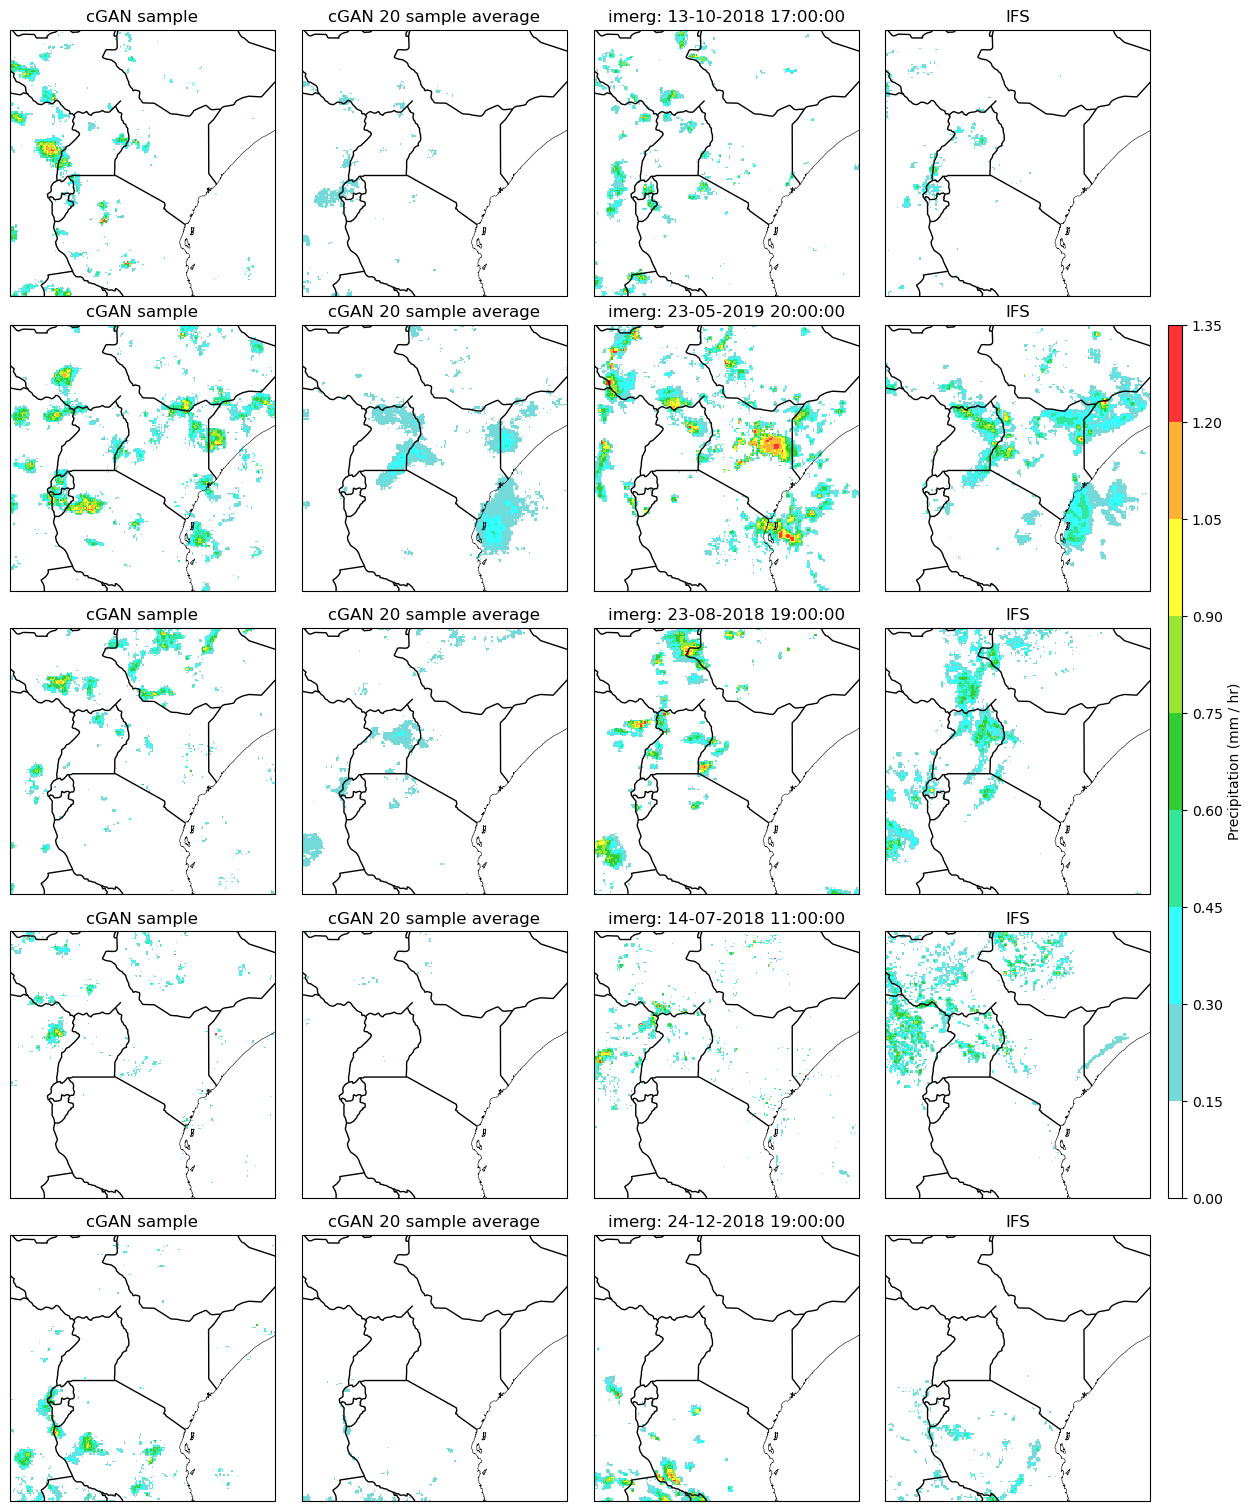

In [5]:
import os
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_precip
import copy
from matplotlib.colors import ListedColormap, BoundaryNorm

denormalise_data = True
batch_gen_iter = iter(data_gen_valid)
noise_channels = config['GENERATOR']['noise_channels']

tp_index = data.all_ifs_fields.index('tp')

# plot configurations

spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)
num_samples = 5
num_rows = num_samples
num_cols = 5
ensemble_size = 20

# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, width_ratios=[1]*(num_cols - 1) + [0.05],
                       wspace=0.01)                      
for row in tqdm(range(num_samples)):

    
    img_gens, truth, fcst, dates, hours = setupdata.generate_prediction(batch_gen_iter, 
                                                                        gen, noise_channels, 
                                                                        batch_size=1, denormalise_data=False,
                                                                        ensemble_size=ensemble_size)
    avg_img_gens = np.add.reduce([item[0, :, :,0] for item in img_gens]) / len(img_gens)
    date_str = dates[0].strftime('%d-%m-%Y') + f' {hours[0]}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[0][0, :, :, 0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN {ensemble_size} sample average'},
                   'imerg' : {'title': f"imerg: {date_str}", 'data': truth[0, :,:,0]},
                   'ifs': {'data': fcst[0, :, :, tp_index], 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[row, col], projection = ccrs.PlateCarree())
        im = plots.plot_precip(np_array=val['data'], ax=ax, levels=precip_levels)
        ax.set_title(val['title'])
        
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[1:-1 ,-1])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink = 0.2, aspect=20)

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_ylabel("Precipitation (mm / hr)")
plt.savefig('cGAN_samples_IFS.png', dpi=fig.dpi)

In [10]:
from dsrnngan import plots

plots.plot_histograms('/user/home/uz22147/logs/cgan/38fba564f1c9852b', val_range =  ['201806', '201905'], ranks=[76800], N_ranks=11)

In [4]:
# Plot bias
import numpy as np
bias_path = '/user/home/uz22147/logs/cgan/38fba564f1c9852b/bias-201806-201905_160000.npz'
bias_fcst_path = '/user/home/uz22147/logs/cgan/38fba564f1c9852b/bias_fcst-201806-201905_160000.npz'
bias = np.load(bias_path)['k']
bias_fcst = np.load(bias_fcst_path)['k']

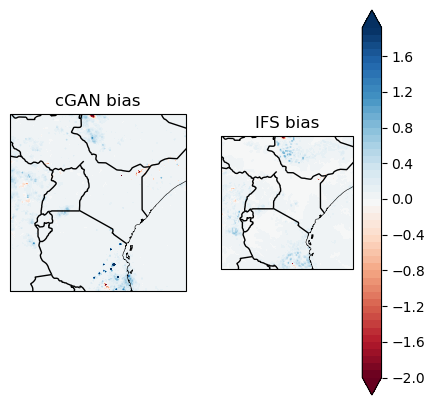

In [63]:
from dsrnngan.plots import default_latitude_range, default_longitude_range, plot_precip
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec

max_level = 2
value_range = list(np.arange(-max_level, max_level, 2*max_level / 50))
fig, ax = plt.subplots(1,2 , subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(5, 5))


im = ax[0].contourf(default_longitude_range, default_latitude_range, bias, transform=ccrs.PlateCarree(),
                    cmap='RdBu', levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')
# , levels=np.arange(-6, 6, 12 / 50))
ax[0].coastlines(resolution='10m', color='black', linewidth=0.4)
ax[0].add_feature(cfeature.BORDERS)
ax[0].set_title('cGAN bias')
# plt.colorbar(im)

im = ax[1].contourf(default_longitude_range, default_latitude_range, bias_fcst, transform=ccrs.PlateCarree(),
                    cmap='RdBu', levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')
# , levels=np.arange(-6, 6, 12 / 50))
ax[1].coastlines(resolution='10m', color='black', linewidth=0.4)
ax[1].add_feature(cfeature.BORDERS)
ax[1].set_title('IFS bias')

plt.colorbar(im, fraction=0.2)

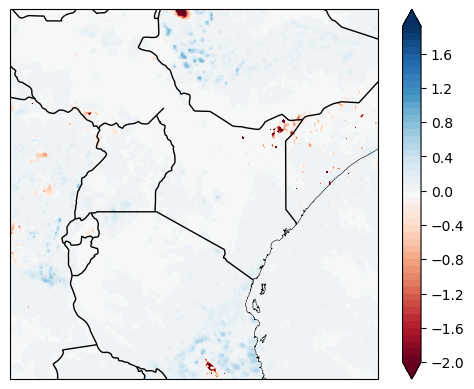

In [55]:
max_level = 2
value_range = list(np.arange(-max_level, max_level, 2*max_level / 50))
fig, ax = plt.subplots(1, 1, subplot_kw={'projection' : ccrs.PlateCarree()})


im = ax.contourf(default_longitude_range, default_latitude_range, bias_fcst, transform=ccrs.PlateCarree(),
                    cmap='RdBu', levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')
# , levels=np.arange(-6, 6, 12 / 50))
ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)

plt.colorbar(im)


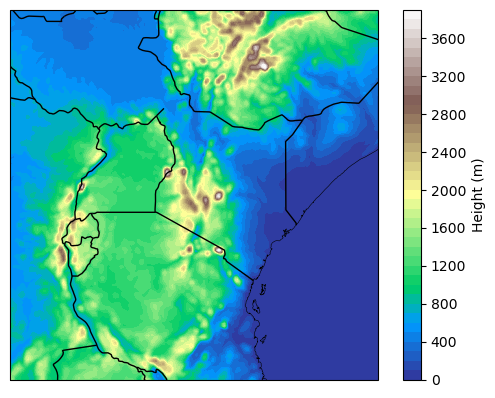

In [66]:
# Load orography to investigate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

colors = plt.cm.terrain(np.linspace(0.25, 1, 200))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)
cmap = plt.get_cmap('terrain')

ds = xr.load_dataset('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/h_HRES_EAfrica.nc')
ds = ds.sel(latitude=default_latitude_range).sel(longitude=default_longitude_range)
ds = ds.isel(time=0)
h_vals = ds['h'].values
h_vals[h_vals < 5] = 5.0
fig, ax = plt.subplots(1, 1, subplot_kw={'projection' : ccrs.PlateCarree()})

im = ax.contourf(default_longitude_range, default_latitude_range, ds['h'].values, transform=ccrs.PlateCarree(),
                    cmap=cmap, levels=np.arange(0, 4000, 100))
ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(im, label='Height (m)')